# Overview

In this notebook I develop the code necessary to prepare raw _Planet_ satellite 
images for the object detection model.The input if is a file/directory path. The file is loaded, clipped to the area of interest provided by the user, and then resized to a size appropriate for labeling by the model. The resized image dimensions are also provided by the user.

## Download Imagery


In [1]:
# Imports here
import os

from google.cloud import storage

# Create the service client.
from googleapiclient.discovery import build
from apiclient.http import MediaIoBaseDownload

In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=OhqbYEUa2KGWnHayw1oMYMXDODJ0WLUj1uONFGkxtI0&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/2QGS_30oJ-RqniJ6Z-_mXv0vqCirlxZvI-gCJK2PPM6FKtll_4TsRG4

You are now logged in as [rcorrero@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey




In [3]:
# GOOGLE CREDS is different for notebook – change for .py files
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
GEO_FILTER_PATH = os.getenv('GEO_FILTER_PATH')
PATH_PREFIX = os.getenv('PATH_PREFIX')
ORDER_ID = os.getenv('ORDER_ID')
ITEM_TYPE = os.getenv('ITEM_TYPE')
ITEM_ID_PATH = os.getenv('ITEM_ID_PATH')
DL_IMAGE_PATH = os.getenv('DL_IMAGE_PATH')
BAND_ID = os.getenv('BAND_ID')

In [4]:
def download_img(dl_path, id_num):
    gcs_service = build('storage', 'v1')
    if not os.path.exists(os.path.dirname(dl_path)):
        try:
            os.makedirs(os.path.dirname(dl_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(dl_path, 'wb') as f:
      # Download the file from the Google Cloud Storage bucket.
      request = gcs_service.objects().get_media(bucket=BUCKET_NAME,
                                                object=dl_path)
      media = MediaIoBaseDownload(f, request)
      print('Downloading image ', id_num, '...')
      print('Download Progress: ')
      done = False
      while not done:
          prog, done = media.next_chunk()
          print(prog.progress())

    print('Image ', id_num, ' downloaded.')
    return dl_path

In [5]:
dl_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
filepath = download_img(dl_path, id_num=0)

Download Progress: 
1.0
Image  0  downloaded.


In [6]:

dl_path[55:-18]

'20161204_181909_0d06'

## Preprocess Imagery


In [7]:
from google.cloud import storage
from skimage.util import view_as_blocks, pad
import math
import numpy as np

from osgeo import gdal, osr, ogr


aoi = r'/content/peru_callao.json'


## Begin Tests


In [118]:
# Determine how much to pad image
img_shape = (256,256)
width, height = img_shape
patch_shape = (20,20)
patch_width, patch_height = patch_shape
width_remainder = width % patch_width
height_remainder = height % patch_height

In [119]:
pad_w = patch_width - width_remainder
pad_h = patch_height - height_remainder

In [120]:
margin_h = int(pad_w / 2)
margin_w = int(pad_h / 2)
x = np.random.random(size=(256,256,3))
x = np.pad(x, [[margin_w, margin_w], [margin_h, margin_h], [0, 0]], 'constant', constant_values=(0))

In [121]:
x.shape

(260, 260, 3)

In [122]:
from sklearn.feature_extraction import image


patches = view_as_blocks(x, (20,20,3))
print(patches.shape)

(13, 13, 1, 20, 20, 3)


In [123]:
def split_img(img_array, patch_shape):
  img_shape = img_array.shape
  width, height = img_shape[:2]
  patch_width, patch_height = patch_shape[:2]
  width_remainder = width % patch_width
  height_remainder = height % patch_height

  pad_w = patch_width - width_remainder
  pad_h = patch_height - height_remainder

  margin_h = int(pad_w / 2)
  margin_w = int(pad_h / 2)
  img_padded = np.pad(img_array, 
                    [[margin_w, margin_w], [margin_h, margin_h], [0, 0]],
                    'constant', constant_values=(0))

  patches = view_as_blocks(img_padded, patch_shape)

  n_horz_patches = patches.shape[0] # Number of patches along x-axis
  n_ver_patches = patches.shape[1] # Number of patches along y-axis
  for i in range(n_horz_patches):
    for j in range(n_ver_patches):
      yield patches[i, j, 0, :, :, :]

In [124]:
x = np.random.random(size=(256,256,3))
for img_split in split_img(x, (20,20)):
  print(img_split)
print(len(list(split_img(x, (20,20)))) == (13 ** 2))

ValueError: ignored

In [ ]:
def get_img_paths(dirpath, bucket_name):
  client = storage.Client()
  for img_path in client.list_blobs('bucketname', prefix=dirpath):
    yield img_path

dirpath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/'
paths = get_img_paths(dirpath, BUCKET_NAME)
for path in paths:
  print(path)

Forbidden: ignored

In [19]:
import math
import json
import numpy as np

from osgeo import gdal, osr


aoi = r'/content/peru_callao.json'

In [ ]:
img_paths = [r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif']
id_start_idx=55
id_end_idx=-18
patch_shape = (2560,2560,3)
for img_path in img_paths:
  item_id = img_path[id_start_idx:id_end_idx]
  ds, (xoff, a, b, yoff, d, e), transform = load_img(img_path)
  img_clipped = clip_img(ds, aoi=r'/content/peru_callao.json')
  print(img_clipped.shape)
  imgs_split = split_img(img_clipped, patch_shape)
  
#  for split in imgs_split:
#    print(split, item_id, (xoff, a, b, yoff, d, e), transform)

(5534, 6546, 3)


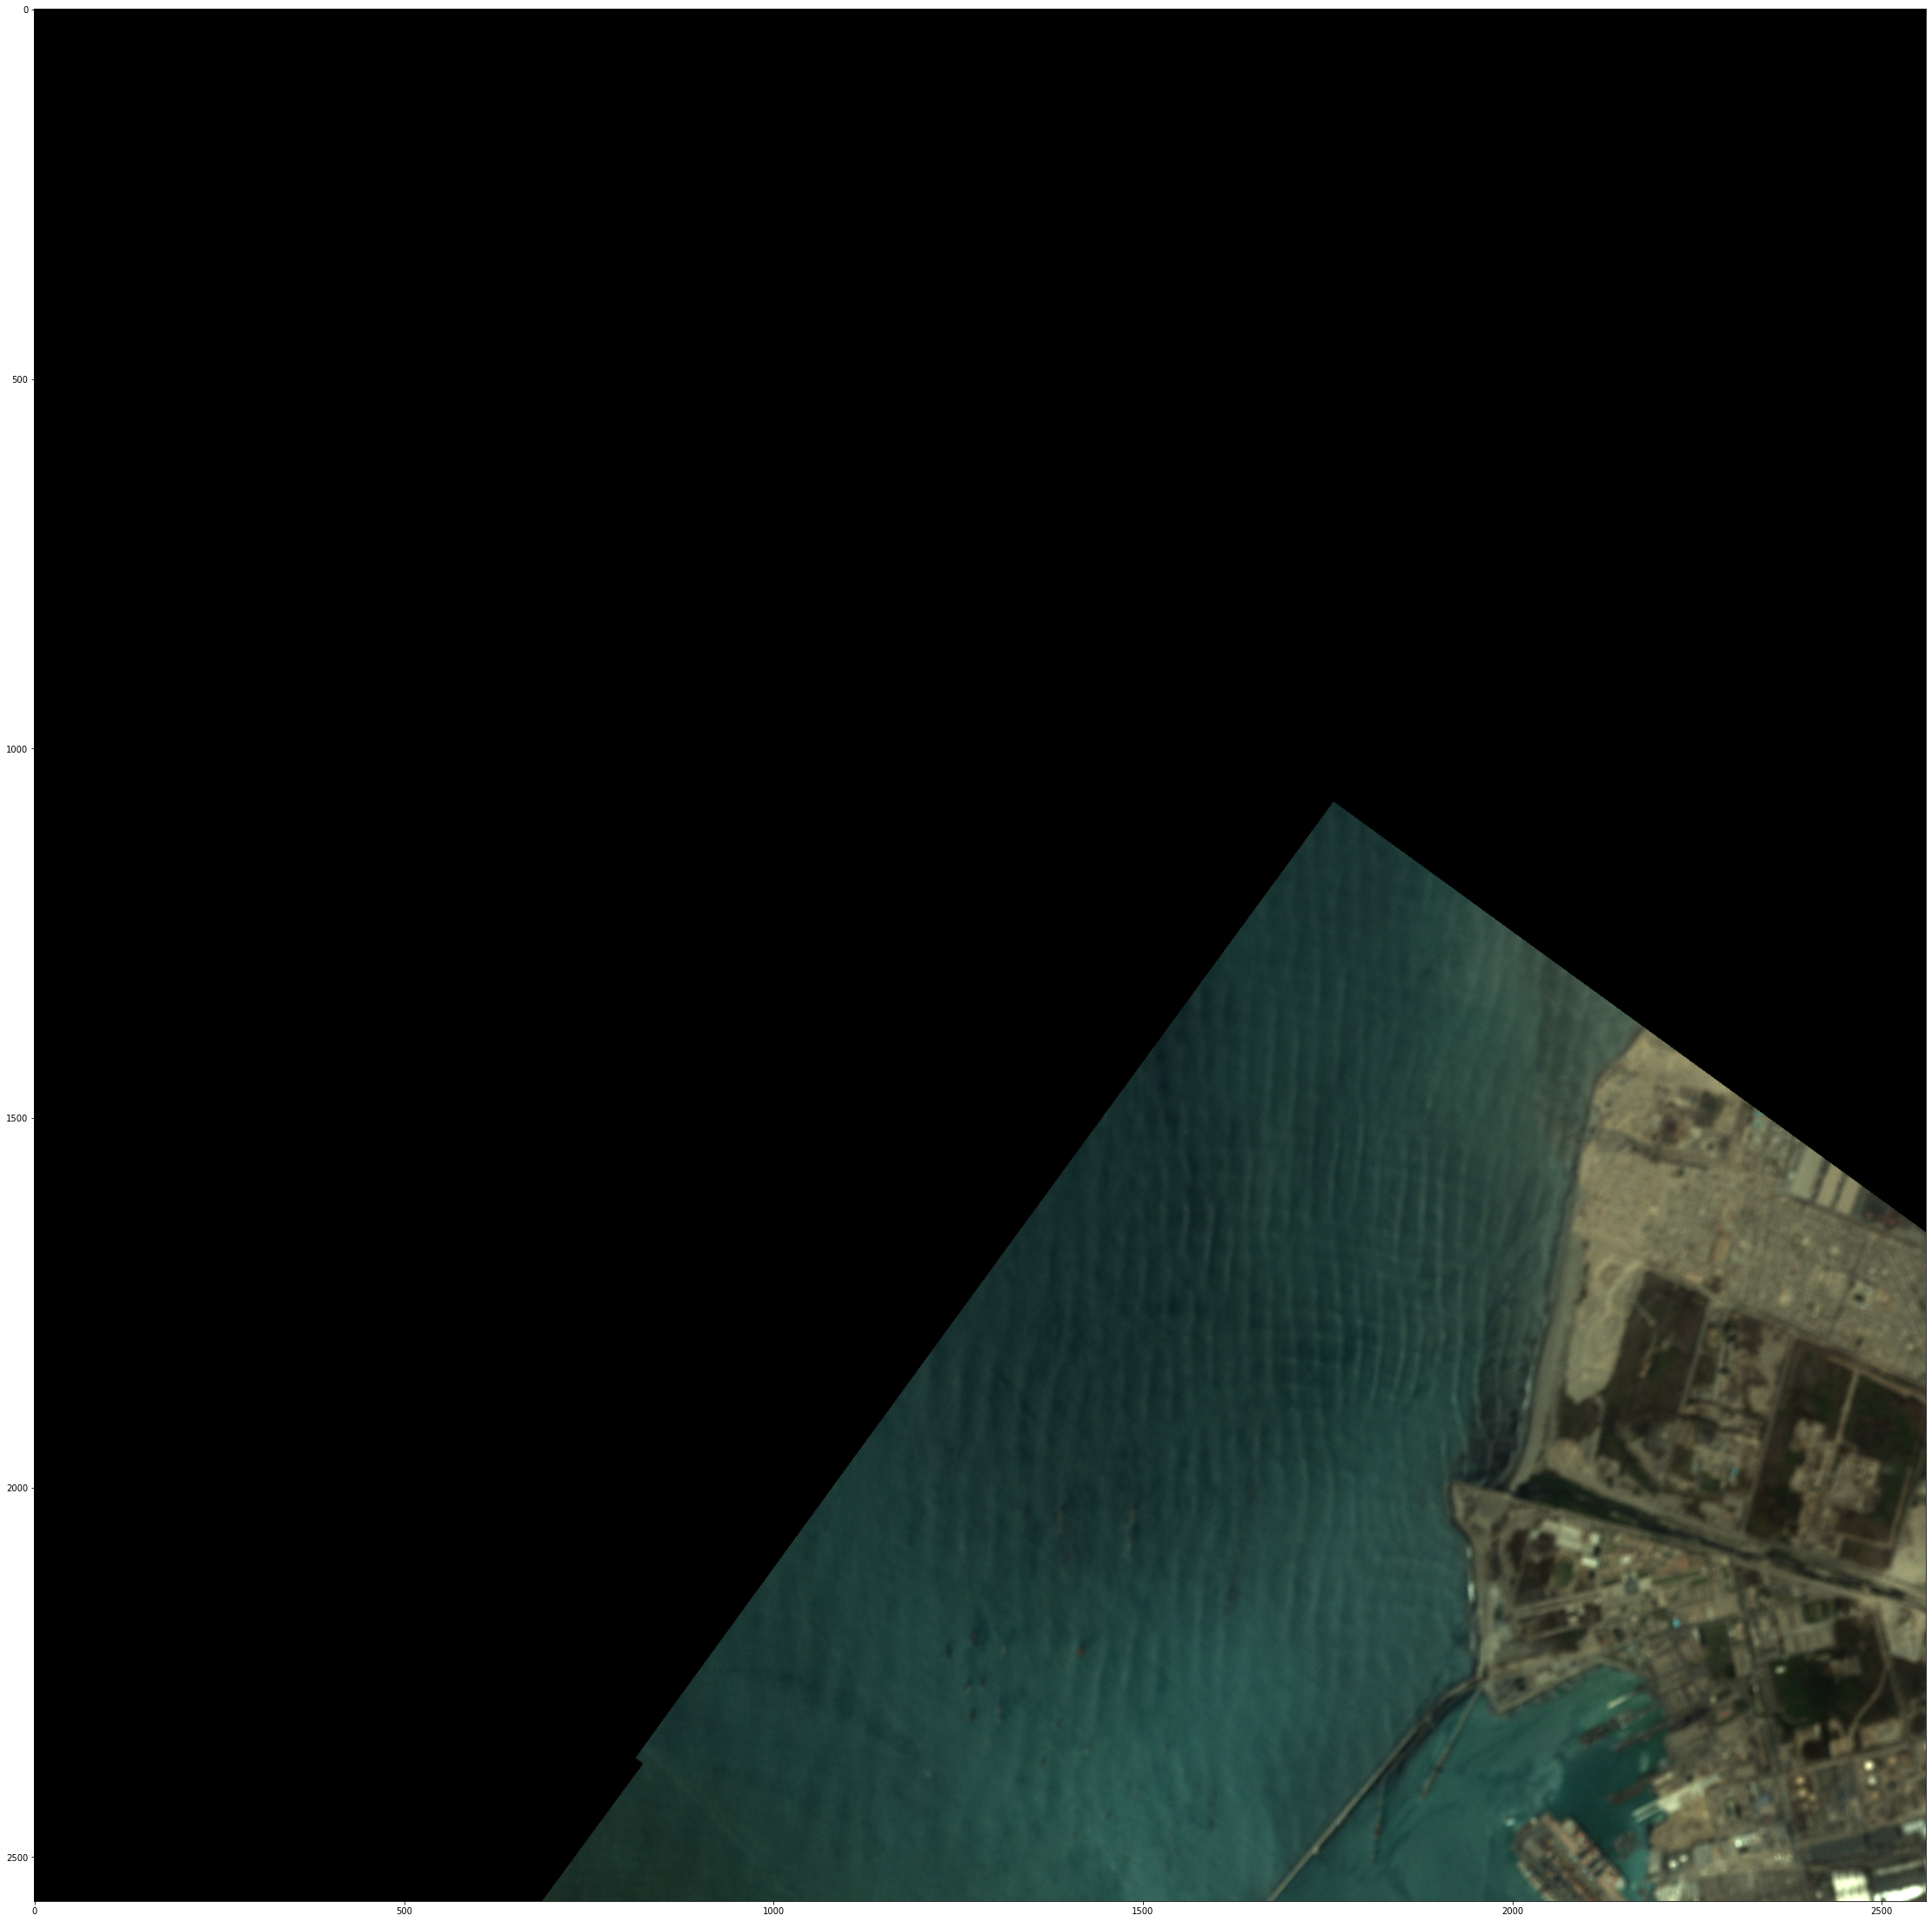

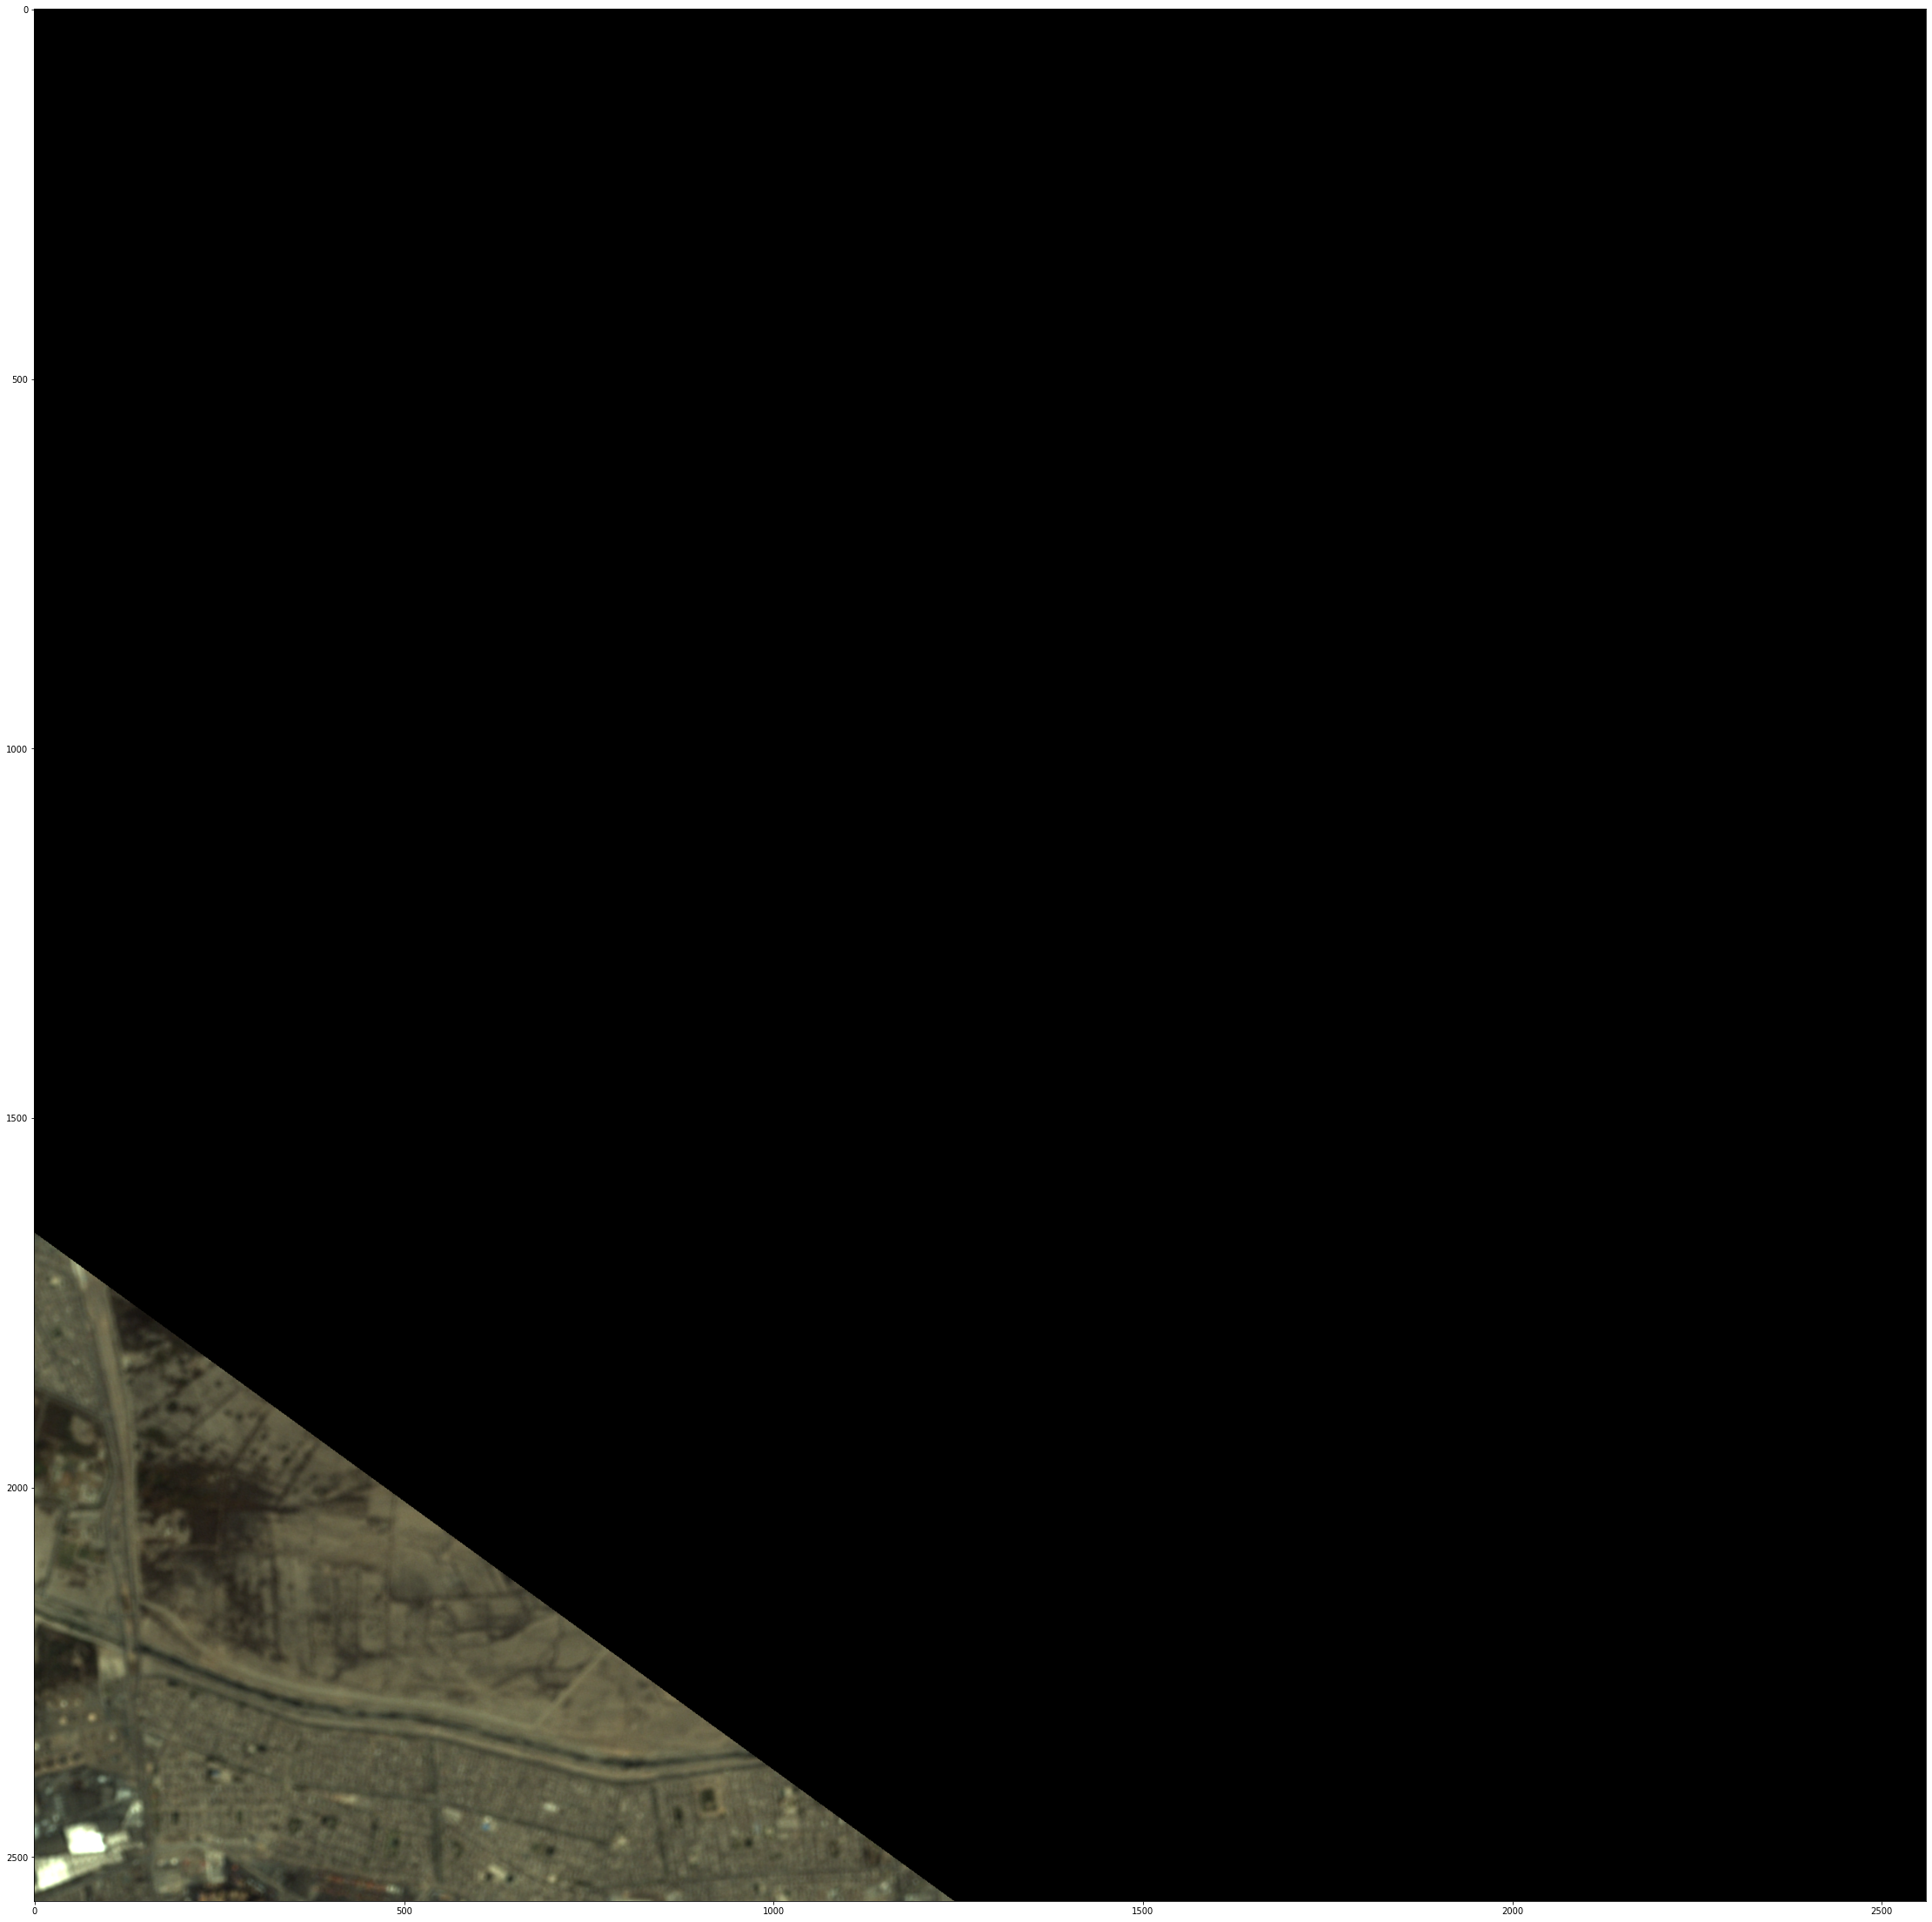

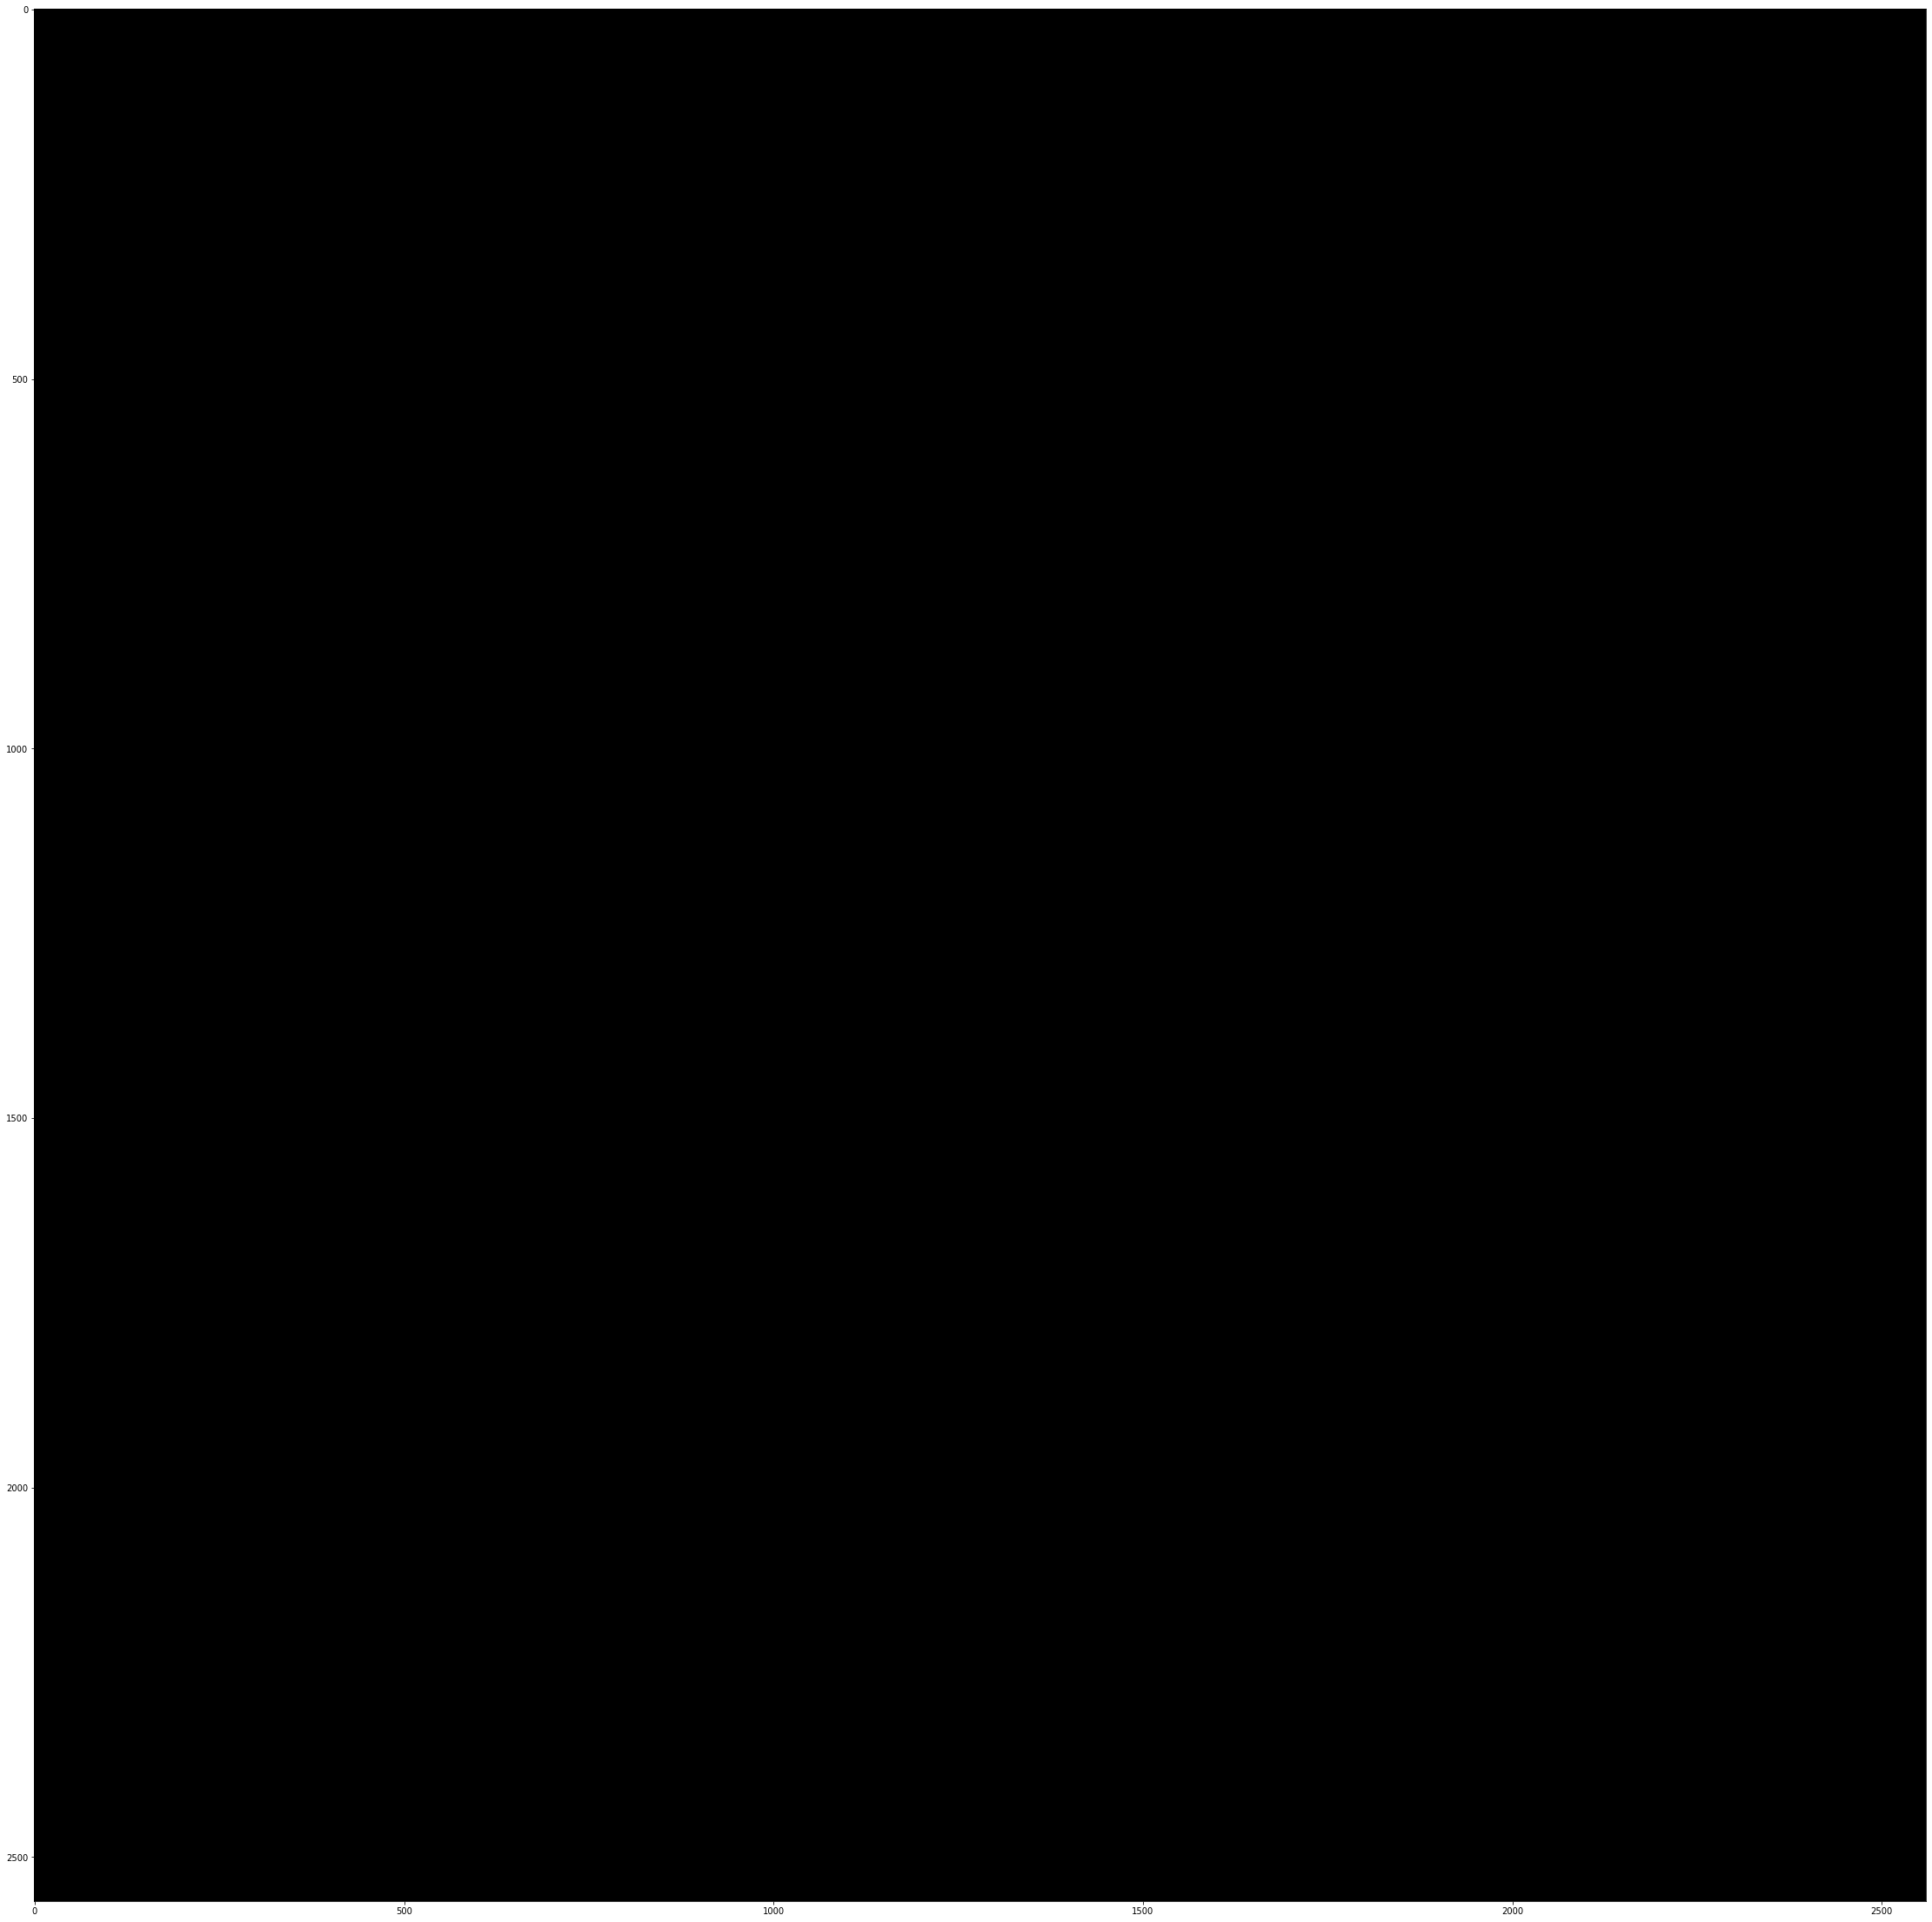

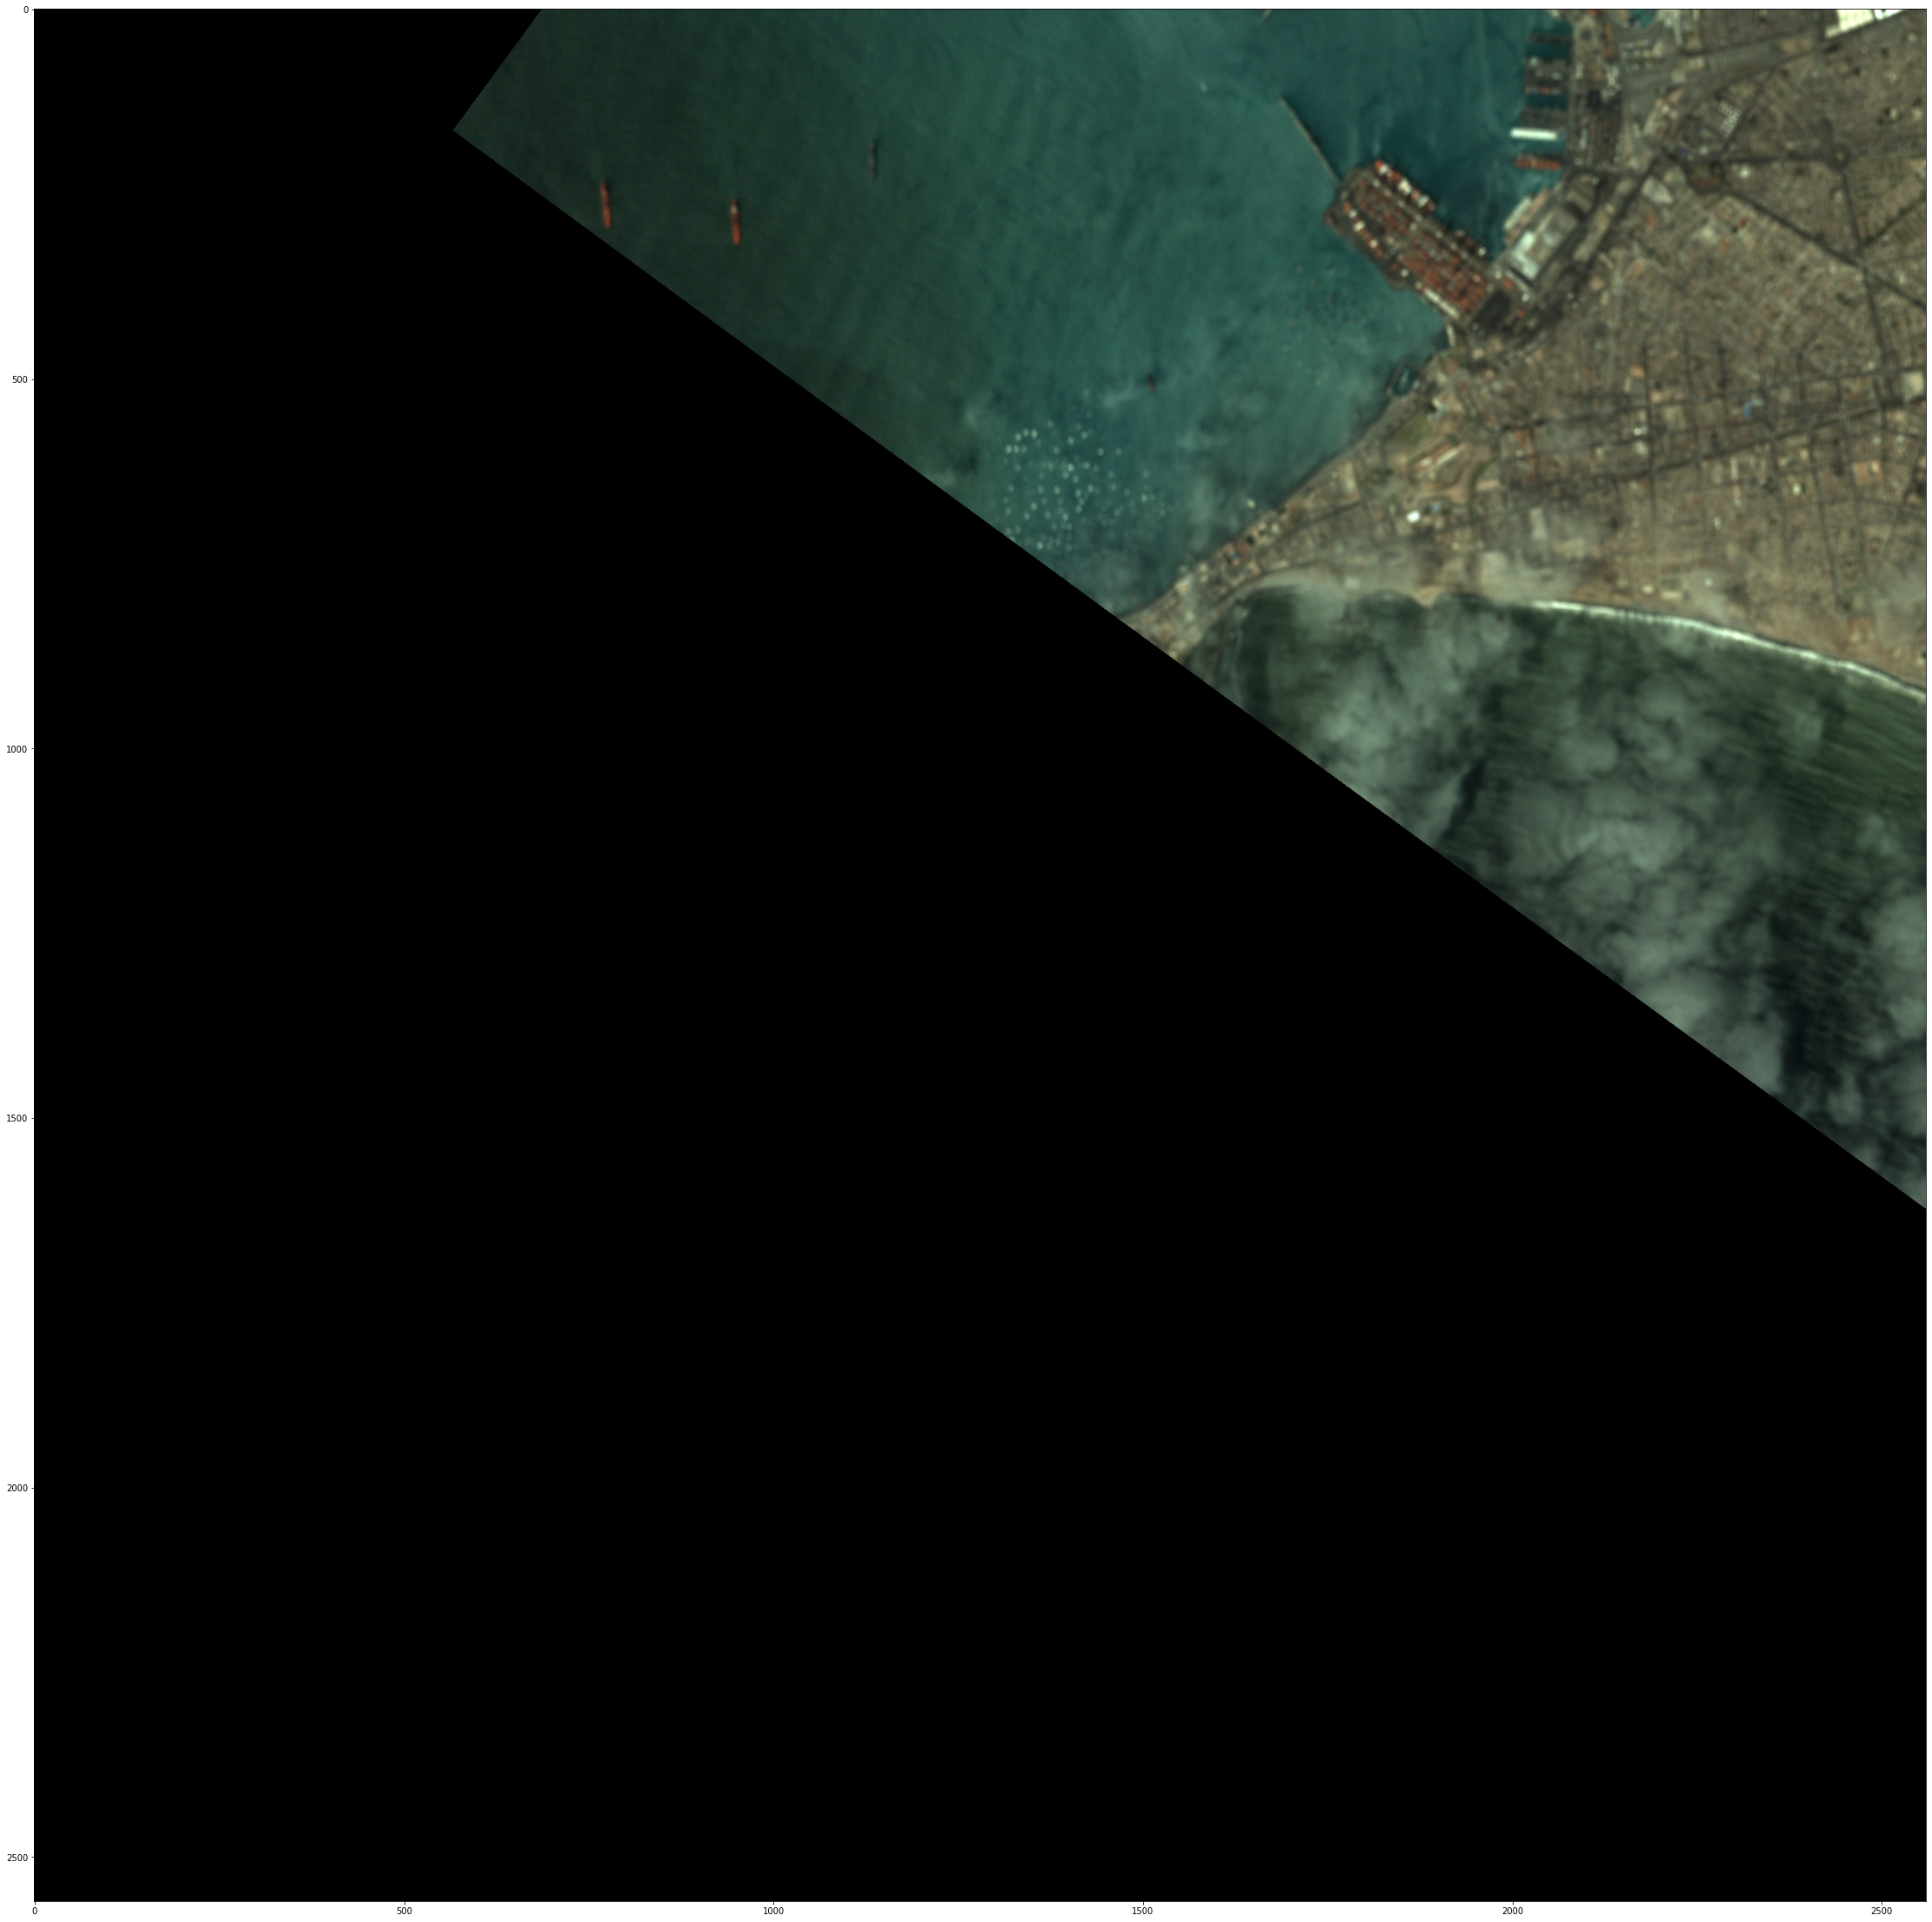

In [ ]:
import matplotlib.pyplot as plt


for idx, split in enumerate(imgs_split):
  # Create figure and axes
  fig,ax = plt.subplots(1, figsize=(40,40))
  # Display the image
  ax.imshow(split[0])
  plt.show()
  if idx > 2:
    break

In [ ]:
for split in imgs_split:
  print(split)

In [116]:
pad_w = 1
pad_h = 4
half_pad_h = pad_h / 2
half_pad_w = pad_w / 2
if half_pad_h < 1 and half_pad_h > 0:
  half_pad_h_1 = 1
else:
  half_pad_h_1 = 0
if half_pad_w < 1 and half_pad_w > 0:
  half_pad_w_1 = 1
else:
  half_pad_w_1 = 0
margin_h = int(half_pad_h)
margin_w = int(half_pad_w)
print(margin_h)
print(margin_w)
max(margin_h, half_pad_h_1)

2
0


2

In [9]:
!pip3 install geojson

In [10]:
import geojson as gj
from osgeo import ogr, osr, gdal

# Enable GDAL/OGR exceptions
gdal.UseExceptions()


# GDAL & OGR memory drivers
GDAL_MEMORY_DRIVER = gdal.GetDriverByName('MEM')
OGR_MEMORY_DRIVER = ogr.GetDriverByName('Memory')


def cut_by_geojson(input_file, output_file, shape_geojson):

    # Get coords for bounding box
    reader = ogr.Open(shape_geojson)
    layer = reader.GetLayer()
    feature = layer.GetFeature(0)
    geoms =json.loads(feature.ExportToJson())['geometry']
    x, y = zip(*gj.utils.coords(geoms))

    min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)

    # Open original data as read only
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)

    bands = dataset.RasterCount

    # Getting georeference info
    transform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    # Getting spatial reference of input raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection)

    # WGS84 projection reference
    OSR_WGS84_REF = osr.SpatialReference()
    OSR_WGS84_REF.ImportFromEPSG(4326)

    # OSR transformation
    wgs84_to_image_trasformation = osr.CoordinateTransformation(OSR_WGS84_REF,
                                                                srs)
    XYmin = wgs84_to_image_trasformation.TransformPoint(min_x, max_y)
    XYmax = wgs84_to_image_trasformation.TransformPoint(max_x, min_y)

    # Computing Point1(i1,j1), Point2(i2,j2)
    i1 = int((XYmin[0] - xOrigin) / pixelWidth)
    j1 = int((yOrigin - XYmin[1]) / pixelHeight)
    i2 = int((XYmax[0] - xOrigin) / pixelWidth)
    j2 = int((yOrigin - XYmax[1]) / pixelHeight)
    new_cols = i2 - i1 + 1
    new_rows = j2 - j1 + 1

    # New upper-left X,Y values
    new_x = xOrigin + i1 * pixelWidth
    new_y = yOrigin - j1 * pixelHeight
    new_transform = (new_x, transform[1], transform[2], new_y, transform[4],
                     transform[5])

    wkt_geom = ogr.CreateGeometryFromJson(str(geoms))
    wkt_geom.Transform(wgs84_to_image_trasformation)

    target_ds = GDAL_MEMORY_DRIVER.Create('', new_cols, new_rows, 1,
                                          gdal.GDT_Byte)
    target_ds.SetGeoTransform(new_transform)
    target_ds.SetProjection(projection)

    # Create a memory layer to rasterize from.
    ogr_dataset = OGR_MEMORY_DRIVER.CreateDataSource('shapemask')
    ogr_layer = ogr_dataset.CreateLayer('shapemask', srs=srs)
    ogr_feature = ogr.Feature(ogr_layer.GetLayerDefn())
    ogr_feature.SetGeometryDirectly(ogr.Geometry(wkt=wkt_geom.ExportToWkt()))
    ogr_layer.CreateFeature(ogr_feature)

    gdal.RasterizeLayer(target_ds, [1], ogr_layer, burn_values=[1],
                        options=["ALL_TOUCHED=TRUE"])

    # Create output file
    driver = gdal.GetDriverByName('GTiff')
    outds = driver.Create(output_file, new_cols, new_rows, bands,
                          gdal.GDT_Float32)

    # Read in bands and store all the data in bandList
    mask_array = target_ds.GetRasterBand(1).ReadAsArray()
    band_list = []

    for i in range(bands):
        band_list.append(dataset.GetRasterBand(i + 1).ReadAsArray(i1, j1,
                         new_cols, new_rows))

    for j in range(bands):
        data = np.where(mask_array == 1, band_list[j], mask_array)
        outds.GetRasterBand(j + 1).SetNoDataValue(0)
        outds.GetRasterBand(j + 1).WriteArray(data)

    outds.SetProjection(projection)
    outds.SetGeoTransform(new_transform)

    target_ds = None
    dataset = None
    outds = None
    ogr_dataset = None

    return output_file

In [102]:
from osgeo import ogr
aoi = '/content/peru_callao.json'

reader = ogr.Open(aoi)
layer = reader.GetLayer()
feature = layer.GetFeature(0)
geoms =json.loads(feature.ExportToJson())['geometry']
print(type(ogr.CreateGeometryFromJson(str(geoms))))
print(type(geoms))
x, y = zip(*gj.utils.coords(geoms))


<class 'osgeo.ogr.Geometry'>
<class 'dict'>


In [18]:
import json 
aoi=b'/content/peru_callao.json'

with open(aoi) as data_file:
    aoi_file = data_file.read()
    print(json.loads(aoi_file, ))
    asd = json.loads(aoi_file, encoding='utf8')
    print(type(ogr.CreateGeometryFromJson(asd)))
    #data_content = json.loads(aoi_file)
    x, y = zip(*gj.utils.coords(gj.loads(aoi_file)))



{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-77.14402198791504, -12.035794936155634], [-77.1509313583374, -12.03969829994496], [-77.157883644104, -12.047043185547468], [-77.14908599853516, -12.060137568764315], [-77.14058876037598, -12.051575928972449], [-77.13698387145996, -12.03814535555251], [-77.14402198791504, -12.035794936155634]]]}}]}


TypeError: ignored

In [63]:
geom = '{"type": "MultiPoint", "coordinates": [[100.0, 0.0], [101.0, 1.0]]}'
geom = ogr.CreateGeometryFromJson(geom)
type(geom)

osgeo.ogr.Geometry

In [74]:
str(gj.loads(aoi_file))

'{"features": [{"geometry": {"coordinates": [[[-77.144022, -12.035795], [-77.150931, -12.039698], [-77.157884, -12.047043], [-77.149086, -12.060138], [-77.140589, -12.051576], [-77.136984, -12.038145], [-77.144022, -12.035795]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}'

In [87]:
ogr.CreateGeometryFromJson(str(gj.loads(aoi_file)))

AttributeError: ignored

In [105]:
img_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
output_file = r'temp.tif'
aoi='/content/peru_callao.json'
clipped_img = gdal.Open(cut_by_geojson(img_path, output_file, aoi),
                        gdal.GA_ReadOnly)

In [109]:
np.array(clipped_img.GetRasterBand(1).ReadAsArray()).shape

(893, 767)

## End Tests

In [85]:
def get_geo_info(ds):
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)
    return (xoff, a, b, yoff, d, e), transform


def load_img(img_path):
  '''Returns both the relevant geographic data, and other metadata such as
   cloudcover etc. and the img itself as a numpy array.
  '''
  ds = gdal.Translate('',
                img_path,
                options='-ot Byte -scale minval maxval -of MEM')
  (xoff, a, b, yoff, d, e), transform = get_geo_info(ds)
  return ds, (xoff, a, b, yoff, d, e), transform


def cut_by_geojson(input_file, output_file, shape_geojson):
    # Get coords for bounding box
    reader = ogr.Open(shape_geojson)
    layer = reader.GetLayer()
    feature = layer.GetFeature(0)
    geoms = json.loads(feature.ExportToJson())['geometry']
    x, y = zip(*gj.utils.coords(geoms))

    min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)

    # Open original data as read only
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)

    bands = dataset.RasterCount

    # Getting georeference info
    transform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    # Getting spatial reference of input raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection)

    # WGS84 projection reference
    OSR_WGS84_REF = osr.SpatialReference()
    OSR_WGS84_REF.ImportFromEPSG(4326)

    # OSR transformation
    wgs84_to_image_trasformation = osr.CoordinateTransformation(OSR_WGS84_REF,
                                                                srs)
    XYmin = wgs84_to_image_trasformation.TransformPoint(min_x, max_y)
    XYmax = wgs84_to_image_trasformation.TransformPoint(max_x, min_y)

    # Computing Point1(i1,j1), Point2(i2,j2)
    i1 = int((XYmin[0] - xOrigin) / pixelWidth)
    j1 = int((yOrigin - XYmin[1]) / pixelHeight)
    i2 = int((XYmax[0] - xOrigin) / pixelWidth)
    j2 = int((yOrigin - XYmax[1]) / pixelHeight)
    new_cols = i2 - i1 + 1
    new_rows = j2 - j1 + 1

    # New upper-left X,Y values
    new_x = xOrigin + i1 * pixelWidth
    new_y = yOrigin - j1 * pixelHeight
    new_transform = (new_x, transform[1], transform[2], new_y, transform[4],
                     transform[5])

    wkt_geom = ogr.CreateGeometryFromJson(str(geoms))
    wkt_geom.Transform(wgs84_to_image_trasformation)

    target_ds = GDAL_MEMORY_DRIVER.Create('', new_cols, new_rows, 1,
                                          gdal.GDT_Byte)
    target_ds.SetGeoTransform(new_transform)
    target_ds.SetProjection(projection)

    # Create a memory layer to rasterize from.
    ogr_dataset = OGR_MEMORY_DRIVER.CreateDataSource('shapemask')
    ogr_layer = ogr_dataset.CreateLayer('shapemask', srs=srs)
    ogr_feature = ogr.Feature(ogr_layer.GetLayerDefn())
    ogr_feature.SetGeometryDirectly(ogr.Geometry(wkt=wkt_geom.ExportToWkt()))
    ogr_layer.CreateFeature(ogr_feature)

    gdal.RasterizeLayer(target_ds, [1], ogr_layer, burn_values=[1],
                        options=["ALL_TOUCHED=TRUE"])

    # Create output file
    driver = gdal.GetDriverByName('GTiff')
    outds = driver.Create(output_file, new_cols, new_rows, bands,
                          gdal.GDT_Float32)

    # Read in bands and store all the data in bandList
    mask_array = target_ds.GetRasterBand(1).ReadAsArray()
    band_list = []

    for i in range(bands):
        band_list.append(dataset.GetRasterBand(i + 1).ReadAsArray(i1, j1,
                         new_cols, new_rows))

    for j in range(bands):
        data = np.where(mask_array == 1, band_list[j], mask_array)
        outds.GetRasterBand(j + 1).SetNoDataValue(0)
        outds.GetRasterBand(j + 1).WriteArray(data)

    outds.SetProjection(projection)
    outds.SetGeoTransform(new_transform)

    target_ds = None
    dataset = None
    outds = None
    ogr_dataset = None

    return output_file


def clip_img(ds, img_path, aoi):
  if aoi is not None:
    # Make gdal options
    new_img_path = cut_by_geojson(img_path, '/content/tempfile.tif', aoi)
    ds = gdal.Translate('',
               new_img_path,
               options='-ot Byte -scale minval maxval -of MEM')
  print('Make sure this works:', ds.GetRasterBand(1).ReadAsArray().shape)

  b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), 
                  ds.GetRasterBand(2).ReadAsArray(), 
                  ds.GetRasterBand(3).ReadAsArray(), 
                  ds.GetRasterBand(4).ReadAsArray())
  img_array = np.array((b3,b2,b1))
  img_array = np.moveaxis(img_array, 0, 2)
  
  return img_array


def split_img(img_array, patch_shape):
  img_shape = img_array.shape
  width, height = img_shape[:2]
  patch_width, patch_height = patch_shape[:2]
  width_remainder = width % patch_width
  height_remainder = height % patch_height

  pad_w = patch_width - width_remainder
  pad_h = patch_height - height_remainder

  half_pad_w = pad_w / 2
  half_pad_w_1 = int(math.ceil(half_pad_w))
  half_pad_w_2 = int(math.floor(half_pad_w))

  half_pad_h = pad_h / 2
  half_pad_h_1 = int(math.ceil(half_pad_h))
  half_pad_h_2 = int(math.floor(half_pad_h))
    
  img_padded = np.pad(img_array, 
                    [[half_pad_w_1, half_pad_w_2], 
                     [half_pad_h_1, half_pad_h_2], 
                     [0, 0]],
                    'constant', constant_values=(0))
  print(img_padded.shape)
  patches = view_as_blocks(img_padded, patch_shape)

  n_horz_patches = patches.shape[0] # Number of patches along x-axis
  n_ver_patches = patches.shape[1] # Number of patches along y-axis
  for i in range(n_horz_patches):
    for j in range(n_ver_patches):
      yield patches[i, j, :, :, :, :]


def get_img_paths(dirpath, bucket_name):
  client = storage.Client()
  for img_path in client.list_blobs('bucketname', prefix=dirpath):
    yield img_path


def prep_imgs(dirpath, bucketname, patch_shape, aoi=None, id_start_idx=55, id_end_idx=-18):
  #img_paths = get_img_paths(dirpath, bucketname)
  img_paths = [r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif']
  for img_path in img_paths:
    item_id = img_path[id_start_idx:id_end_idx]
    ds, (xoff, a, b, yoff, d, e), transform = load_img(img_path)
    img_clipped = clip_img(ds, img_path, aoi)
    imgs_split = split_img(img_clipped, patch_shape)
    for split in imgs_split:
      print(split.shape)
      yield split[0,:,:,:], item_id, (xoff, a, b, yoff, d, e), transform

## Load Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [25]:
import torch
from torchvision.transforms import functional as F



state_dict = r'/content/maskrcnn_resnet50_state_dict.pth'

model = get_instance_segmentation_model(2)
model.load_state_dict(torch.load(state_dict))

<All keys matched successfully>

In [26]:
device = torch.device('cuda')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

## Process Results

In [15]:
import pandas as pd

from datetime import datetime
from osgeo import gdal, osr


def make_df(rows=None):
    col_names = ['target_id', 'item_id', 'datetime', 'probability', 'latitude', 'longitude',
                'bounding_box', 'area', 'major_length', 'minor_length']
    df = pd.DataFrame(columns=col_names)
    #df.set_index('target_id')
    if rows is not None:
          df = df.append(rows)
    return df


def get_datetime(item_id):
    datetime_str = item_id[:15]
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    return datetime_obj


def get_bboxes(prediction, thresh=0.5):
    '''Selects only those bounding boxes associated with 
    probabilities greater than threshold.
    '''
    scores =  prediction['scores'].cpu().numpy()
    filtered_idx = np.where(scores > thresh)
    bboxes = prediction['boxes'].cpu().numpy()
    bboxes = bboxes[filtered_idx]
    return list(zip(scores[filtered_idx], bboxes))


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        

        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return list(zip(results, lat_long_list))


def convert_px_to_lat_long(results, coords, transform):
    xoff, a, b, yoff, d, e = coords
    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_y = x0 + ((x1 - x0) / 2)
        center_x = y0 + ((y1 - y0) / 2)
        
        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
    return lat_long_list


def add_results(rows, datetime, item_id, df, m_per_pix=3.0):
    row_list = []
    for idx, target in enumerate(rows):
        target_id = item_id + '_'  + str(idx)
        probability = target[0][0]
        latitude = target[1][0]
        longitude = target[1][1]

        bounding_box = target[0][1]
        x0, y0, x1, y1 = bounding_box
        diff_y = (y1 - y0) * m_per_pix
        diff_x = (x1 - x0) * m_per_pix
        area = diff_y * diff_x
        major_length = max(diff_y, diff_x)
        minor_length = min(diff_y, diff_x)

        row_list.append({'target_id':target_id, 'item_id':item_id, 'datetime':datetime, 
                   'probability':probability, 'latitude':latitude, 'longitude':longitude, 
                   'bounding_box':bounding_box, 'area':area, 'major_length':major_length, 
                   'minor_length':minor_length}) #ignore_index=True)
    df = df.append(rows)
    return df
        
        
def process_outputs(prediction, item_id, coords, transform,
                    thresh=0.5, m_per_pix=3.0):
    if prediction[0]['scores'].cpu().numpy().shape[0] < 1:
        return
    datetime = get_datetime(item_id)    
    results = get_bboxes(prediction[0], thresh)
    rows = list(zip(results, convert_px_to_lat_long(results, 
                                                    coords, 
                                                    transform)))
    return rows

# Tests

In [102]:
if __name__ == '__main__':
  dirpath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/'
  aoi = r'/content/peru_callao.json'
  imgs = prep_imgs(dirpath, BUCKET_NAME, (256,256, 3), aoi, id_start_idx=55, id_end_idx=-18)
  rows = []
  model.eval()
  for img, item_id, (xoff, a, b, yoff, d, e), transform in imgs:
    print(img.shape)
    # Label the image
    image = F.to_tensor(img)
    print(image)
    with torch.no_grad():
      try:
        prediction = model([(image).to(device)])
      except RuntimeError:
        print('oh NOO')
    # Add data to df list
    new_rows = process_outputs(prediction, item_id, (xoff, a, b, yoff, d, e), transform)
    if new_rows is not None:
      print(new_rows)
      rows.append(new_rows)
  df = make_df(rows)

Make sure this works: (893, 767)
(1024, 768, 3)
(1, 256, 256, 3)
(256, 256, 3)
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1451, 0.1765, 0.2118],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.1961, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.2196, 0.2392]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1569, 0.1882, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.1804, 0.2039, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.2118, 0.2196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.00

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


TypeError: ignored

In [103]:
rows

[]

In [101]:
len( [(0.8990485,
)])

1

In [92]:
df.head()

0 area  ... probability target_id
0                                               None  NaN  ...         NaN       NaN
1                                               None  NaN  ...         NaN       NaN
2  ((0.8990485, [41.729076, 0.0, 79.440216, 50.44...  NaN  ...         NaN       NaN
3                                               None  NaN  ...         NaN       NaN
4                                               None  NaN  ...         NaN       NaN

[5 rows x 11 columns]

In [ ]:
dl_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
filepath = download_img(dl_path, id_num=0)